In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy
import pylab
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import copy

In [2]:
df = pd.read_csv("/content/shopping_behavior.csv")

In [3]:
df.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


# EDA

**Проверим наличие пустых ячеек**

In [5]:
df.info() #пустых ячеек нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

**Проведем дополнительную проверку**

In [6]:
df.isna().sum() # чтд, нулевых ячеек нет

Customer ID               0
Age                       0
Gender                    0
Item Purchased            0
Category                  0
Purchase Amount (USD)     0
Location                  0
Size                      0
Color                     0
Season                    0
Review Rating             0
Subscription Status       0
Shipping Type             0
Discount Applied          0
Promo Code Used           0
Previous Purchases        0
Payment Method            0
Frequency of Purchases    0
dtype: int64

- в нашем кейсе пропусков нет
- но если были бы, то можно было бы: удалить пропуски, заполнить медианой, средним, модой или отдельным значением, которое не будет похоже на остальные

**Посмотрим ближе на данные**

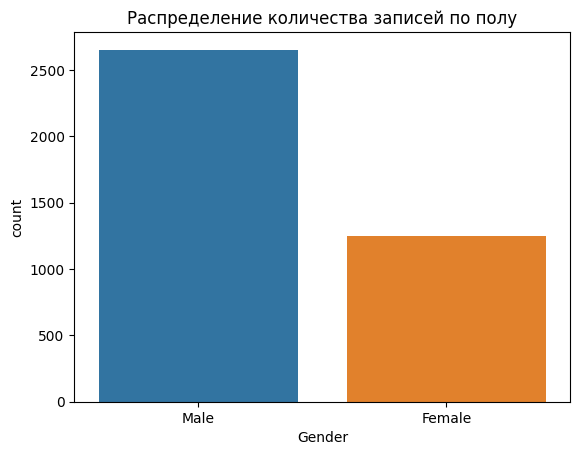

In [7]:
plt.title("Распределение количества записей по полу")
sns.countplot(data=df, x = 'Gender');

- Количество мужчин, совершивших покупку за исследуемый период, почти в два раза больше

**Рассмотрим распределение кол-ва клиентов в разрезе типа оплаты и пола клиента**

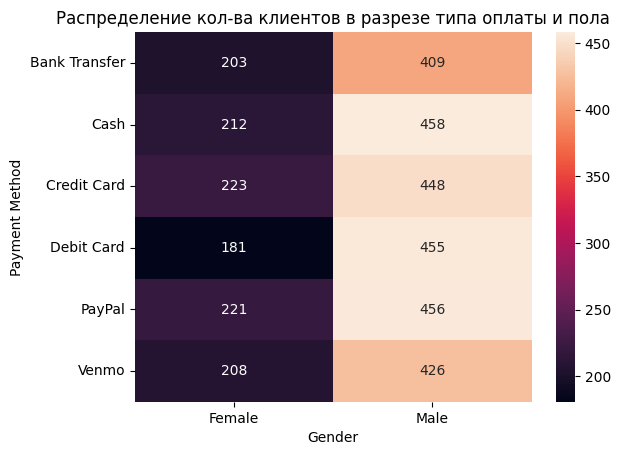

In [8]:
cur_gr_df = df.groupby(by=['Gender', 'Payment Method'])['Customer ID'].count().to_frame().reset_index()
cur_gr_df = cur_gr_df.pivot(index='Payment Method', columns='Gender', values='Customer ID')
plt.title("Распределение кол-ва клиентов в разрезе типа оплаты и пола")
sns.heatmap(cur_gr_df, annot=True, fmt=".0f");

Вспомним о том, что у нас кол-во мужчин совершавших покупки почти в два раза больше. Тем не менее, исходя из тепловой карты, женщины чаще всего пользовались paypal и кредитной картой, а мужчины наличными (458 товаров), дебетовой картой и paypal

**Теперь посмотрим на распределение клиентов в разререзе типа и пола**

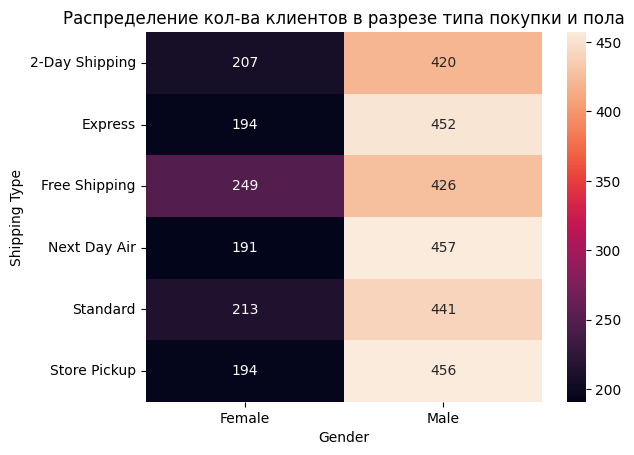

In [9]:
cur_gr_df = df.groupby(by=['Gender', 'Shipping Type'])['Customer ID'].count().to_frame().reset_index()
cur_gr_df = cur_gr_df.pivot(index='Shipping Type', columns='Gender', values='Customer ID')
plt.title("Распределение кол-ва клиентов в разрезе типа покупки и пола")
sns.heatmap(cur_gr_df, annot=True, fmt=".0f");

Исходя из приведенной выше тепловой карты, можно сделать вывод что женщины чащк всего совершают покупки "free shipping", "standart" и "2-day shipping". Мужчины же наоборот чаще всего покупают в формате "next-day air", "store pickup" и "express". Возможно, женщине нужно больше времени для принятия решения о покупке и ей важно ходить, примерять оффлайн. Мужчина же предпочитает скорее онлайн формат.

**Теперь рассмотрим распределение кол-ва клиентов по частоте в разрезе гендера**

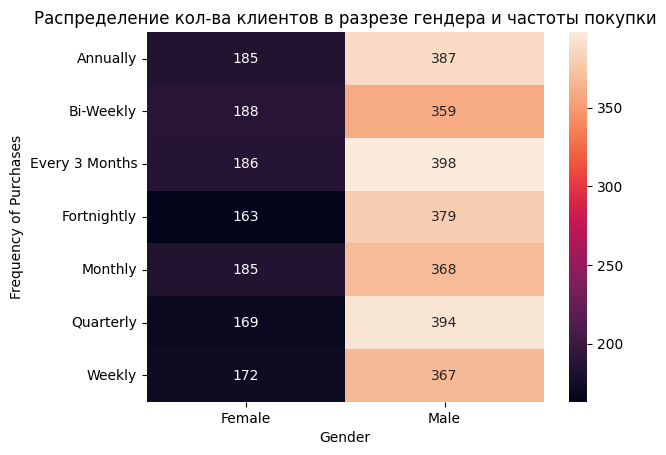

In [10]:
cur_gr_df = df.groupby(by=['Gender', 'Frequency of Purchases'])['Customer ID'].count().to_frame().reset_index()
cur_gr_df = cur_gr_df.pivot(index='Frequency of Purchases', columns='Gender', values='Customer ID')
plt.title("Распределение кол-ва клиентов в разрезе гендера и частоты покупки")
sns.heatmap(cur_gr_df, annot=True, fmt=".0f");

На тепловой карте выше видно, что клиенты-женщины исследуемого магазина немного чаще покупают товары, чем мужины. У них большинство товаров куплено раз в месяц, раз в три месяца и раз в две недели. У мужчин же преобладают покупки раз в 3 месяца, поквартально и ежегодно.

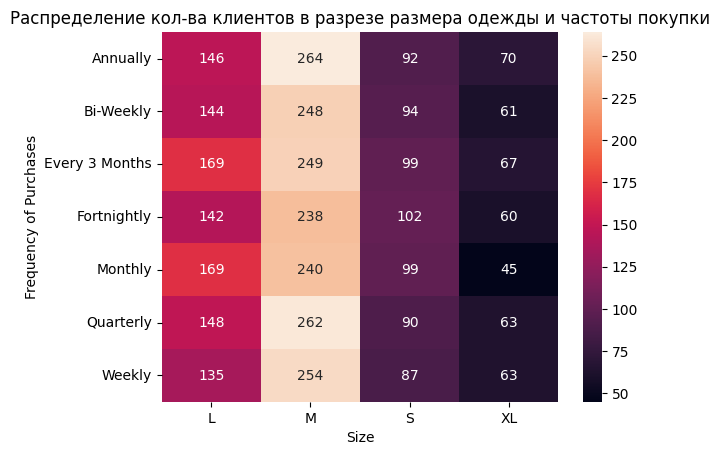

In [11]:
cur_gr_df = df.groupby(by=['Size', 'Frequency of Purchases'])['Customer ID'].count().to_frame().reset_index()
cur_gr_df = cur_gr_df.pivot(index='Frequency of Purchases', columns='Size', values='Customer ID')
plt.title("Распределение кол-ва клиентов в разрезе размера одежды и частоты покупки")
sns.heatmap(cur_gr_df, annot=True, fmt=".0f");

Исходя из тепловой карты выше, можно сделать вывод что наиболее популярные размеры у клиентов это M и L, затем S и XL. Этот тренд сохраняется на всех типах частоты покупки.

**Посмотрим на топ-10 штатов в которых совершались покупки**

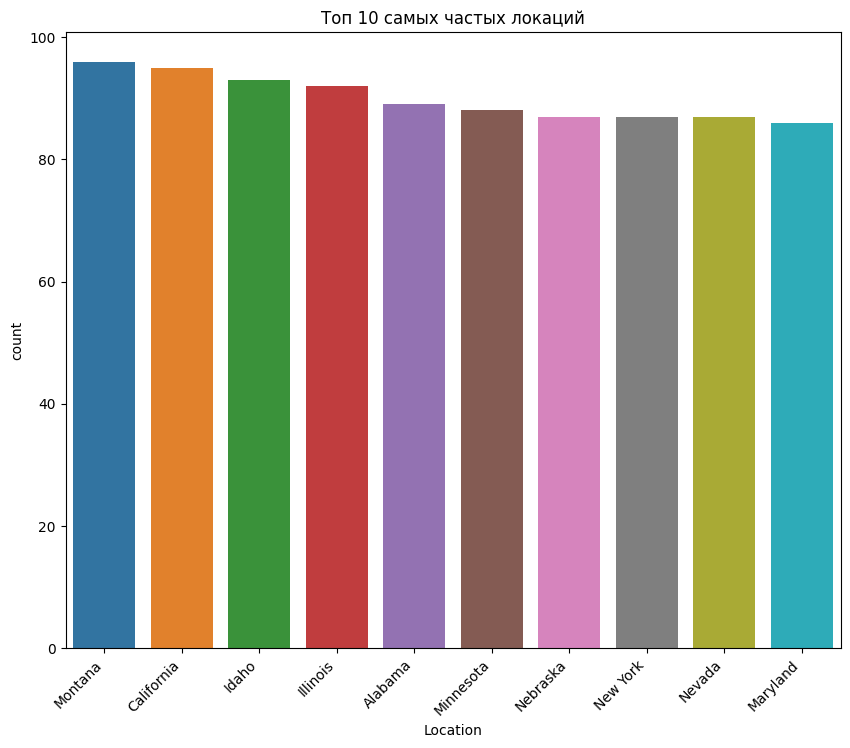

In [12]:

# Подсчитываем количество записей для каждой локации
location_counts = df['Location'].value_counts()

# Выбираем топ 10 самых частых локаций
top_locations = location_counts.head(10).index

# Фильтруем датасет для включения только топ 10 локаций
top_locations_df = df[df['Location'].isin(top_locations)]

# Создаем график
plt.figure(figsize=(10, 8)) # Можно настроить размер фигуры по желанию
plt.title("Топ 10 самых частых локаций")
sns.countplot(data=top_locations_df, x='Location', order=top_locations)

# Для улучшения читаемости можно повернуть подписи оси X
plt.xticks(rotation=45, ha='right')

# Показываем график
plt.show()


Наиболее часто встречаемые штаты в данных по покупкам - Монтана, Калифорния, Айдахо и пр. показанные на гистограмме

**Теперь рассмотрим топ-10 наиболее популярных цветов товаров**

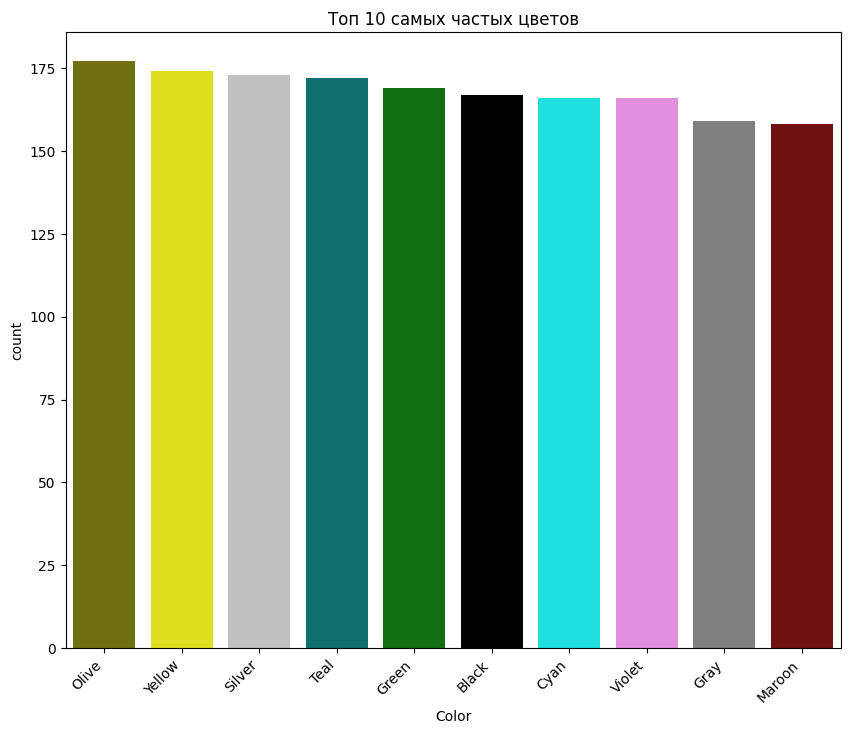

In [13]:

# Подсчитываем количество записей для каждого цвета
color_counts = df['Color'].value_counts()

# Выбираем топ 10 самых частых цветов
top_colors = color_counts.head(10).index

# Фильтруем датасет для включения только топ 10 цветов
top_colors_df = df[df['Color'].isin(top_colors)]

# Определяем цвета для столбцов в порядке от наиболее частого к наименее
bar_colors = ['Olive', 'Yellow', 'Silver', 'Teal', 'Green',
              'Black', 'Cyan', 'Violet', 'Gray', 'Maroon']

# Создаем график
plt.figure(figsize=(10, 8))
plt.title("Топ 10 самых частых цветов")
sns.countplot(data=top_colors_df, x='Color', order=top_colors, palette=bar_colors)

# Для улучшения читаемости можно повернуть подписи оси X
plt.xticks(rotation=45, ha='right')

# Показываем график
plt.show()


Чаще всего покупали товары оливкового, желтого, серебренного и прочие на графике.

**Рассмотрим какие товары покупали потребители чаще всего иза исследуемый период в разпезе категорий.**

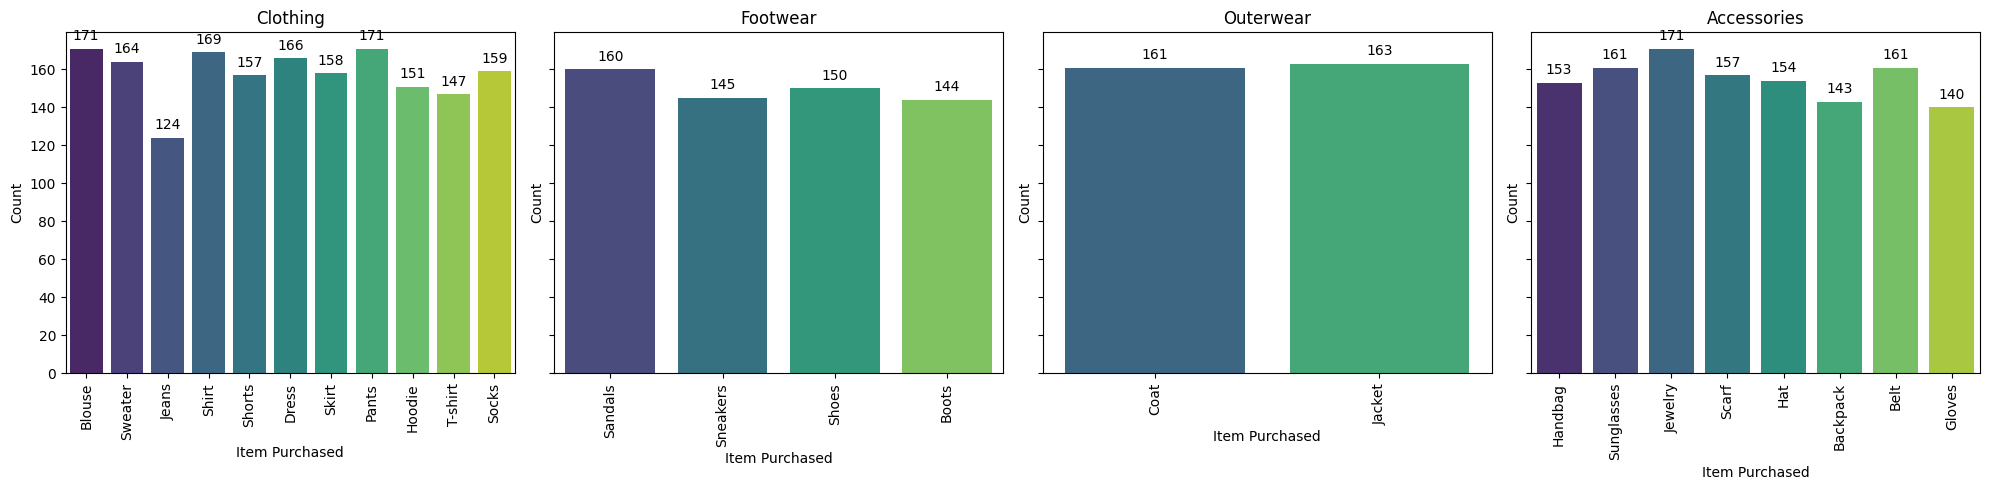

In [14]:


# Создаем новую фигуру и набор осей для каждой категории товаров
fig, axes = plt.subplots(nrows=1, ncols=len(df['Category'].unique()), figsize=(20, 5), sharey=True)

# Создаем отдельный график для каждой категории
categories = df['Category'].unique()
for ax, category in zip(axes, categories):
    category_data = df[df['Category'] == category]
    sns.countplot(data=category_data, x='Item Purchased', ax=ax, palette='viridis')
    ax.set_title(category)
    ax.set_xlabel('Item Purchased')
    ax.set_ylabel('Count')

    # Добавляем значения на каждый столбец
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 9),
                    textcoords = 'offset points')

    ax.tick_params(axis='x', rotation=90)  # Поворачиваем подписи оси X

plt.tight_layout()
plt.show()


На представленном гафике четыре группы столбчатых графиков отображают количество покупок различных товаров внутри четырех основных категорий: Clothing (Одежда), Footwear (Обувь), Outerwear (Верхняя одежда), и Accessories (Аксессуары).

Каждый столбец в графике окрашен в уникальный цвет и помечен названием товара, а также числом, представляющим количество покупок этого товара. Наблюдения по каждой категории:

Clothing (Одежда):
Самые популярные пункты покупок включают Blouse (Блузка) и Pants (Брюки) с 171 и 171 покупками соответственно.
Наименее популярными товарными позициями являются Jeans (Джинсы) и T-Shirt (футболка) с 124 и 147 покупками соответственно.

Footwear (Обувь):
Sneakers (Кроссовки) и Boots (Ботинки) имеют примерно одинаковое количество покупок, 145 и 144 соответственно.
Boots (Ботинки) имеют наименьшее количество покупок в этой категории с 144.

Outerwear (Верхняя одежда):
Jacket (Куртка) была куплена 163 раза, что делает её самым популярным товаром в этой категории.
Coat (Пальто) приобреталось чуть реже - 161 покупка.

Accessories (Аксессуары):
Jewelry (Ювелирные изделия) оказались наиболее популярными с 171 покупкой.
Gloves (Перчатки) наименее популярны в этой категории с 140 покупками.
Графики также показывают, что распределение покупок в каждой категории относительно равномерное, без сильных выбросов или аномалий. Это может свидетельствовать о стабильном спросе на большинство представленных товаров в каждой категории.

**Рассмотрим распределение цены товара в зависимости от его рейтинга**

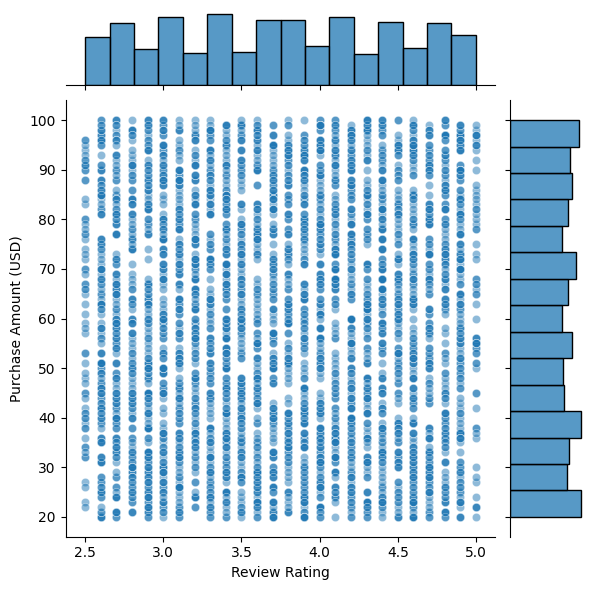

In [15]:


# Создаем совместный график с распределениями по краям
sns.jointplot(x='Review Rating', y='Purchase Amount (USD)', data=df, kind='scatter', alpha=0.5)

# Показываем график
plt.show()


Основная диаграмма показывает следующее:
Горизонтальная ось (ось X): Отображает рейтинг отзывов. Значения рейтинга распределены от примерно 2.5 до 5.0, что может указывать на шкалу оценок от 1 до 5, где 5 — это наивысший рейтинг.
Вертикальная ось (ось Y): Показывает сумму покупки в долларах США. Значения, похоже, варьируются от менее 10 до более 100 долларов.
Гистограммы по краям показывают распределение каждой из этих переменных отдельно:

Закономерность зависимости центы от рейтинга глазами не увидеть.

**Рассмотрим какие категории товаров наиболее популярны**

In [16]:
category_df = df.groupby('Category')['Customer ID'].count().to_frame().reset_index()

In [17]:
category_df

,Category,Customer ID
0,Accessories,1240
1,Clothing,1737
2,Footwear,599
3,Outerwear,324


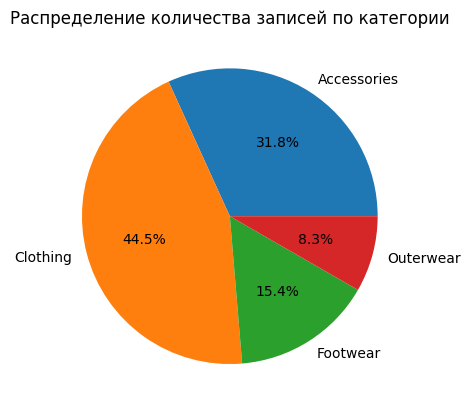

In [18]:
plt.title("Распределение количества записей по категории")
plt.pie(x=category_df['Customer ID'], labels=category_df['Category'], autopct='%.1f%%');

Наиболее популярные товары находятся в категории одежды и аксессуаров

**Рассмотрим распределение возраста клиентов в разрезе пола**

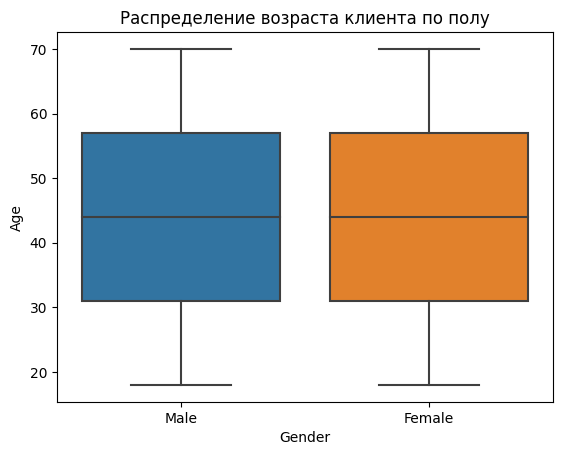

In [19]:
plt.title("Распределение возраста клиента по полу")
sns.boxplot(data=df, y='Age', x='Gender');

На этом боксплоте (ящик с усами) показано распределение возраста клиентов в зависимости от пола. Синий ящик представляет мужчин, а оранжевый — женщин.

Из графика можно сделать следующие выводы:
Центральная линия в каждом ящике показывает медиану возраста для мужчин и женщин. Обе медианы кажутся схожими, что указывает на то, что средний возраст клиентов обоих полов примерно одинаков на уровне 45 года

Здесь нет видимых точек, которые обозначали бы выбросы, поэтому можно предположить, что все данные о возрасте находятся внутри ожидаемого диапазона.

**Теперь посмотрим сколько покупок совершали клиенты в разрезе пола. Смотрим кол-во предыдущих покупок + 1 из базы данных**

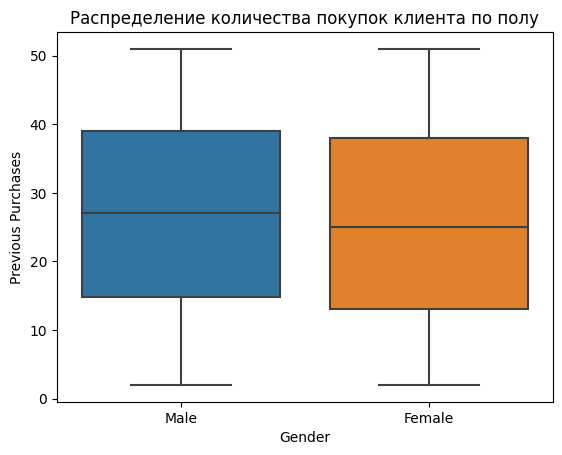

In [20]:
a = df['Previous Purchases']+1

plt.title("Распределение количества покупок клиента по полу")
sns.boxplot(data=df, y=a, x='Gender');

Центральная линия внутри каждого ящика указывает на медиану количества покупок. Кажется, что медиана для мужчина немного выше, чем для женщие, что может указывать на то, что мужины в среднем совершают больше покупок.

Высота ящиков представляет IQR, который показывает диапазон, в котором находится центральная половина данных. Для обеих групп IQR примерно одинаков, что означает, что вариативность количества покупок у мужчин и женщин схожа.

Усы, выходящие из ящиков, показывают весь диапазон данных, исключая выбросы.
На графике отсутствуют точки, которые представляли бы выбросы. Это означает, что нет экстремально высоких или низких значений, которые сильно отклоняются от основного распределения данных.

**Рассмотрим в разрезе сезонности и суммы покупки мужчин и женщин. Для этого подготовим табличку и построим боксплот**

In [21]:
sex_season_df = df.groupby(['Gender', 'Season', 'Payment Method'])['Purchase Amount (USD)'].mean().to_frame().reset_index()
sex_season_df.head()

,Gender,Season,Payment Method,Purchase Amount (USD)
0,Female,Fall,Bank Transfer,58.181818
1,Female,Fall,Cash,61.516667
2,Female,Fall,Credit Card,64.115385
3,Female,Fall,Debit Card,60.039216
4,Female,Fall,PayPal,64.404255


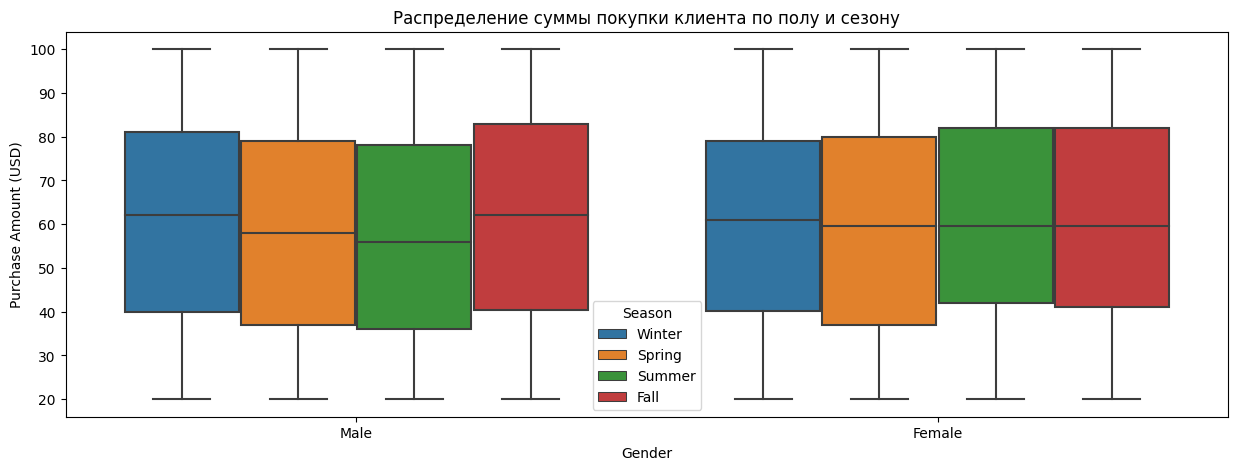

In [22]:
plt.figure(figsize=(15, 5))
plt.title("Распределение суммы покупки клиента по полу и сезону")
sns.boxplot(data=df, y='Purchase Amount (USD)', x='Gender', hue='Season');

На представленном боксплоте (ящик с усами) показано распределение суммы покупки клиента в долларах США в зависимости от пола и сезона. Боксплоты разделены на две группы: мужчины и женщины. В каждой группе представлены четыре сезона: зима (синий), весна (оранжевый), лето (зеленый) и осень (красный).

Каждый боксплот показывает медиану (центральная линия в ящике), 25-й (нижний край ящика) и 75-й (верхний край ящика) процентили, а также максимальные и минимальные значения (усы), исключая выбросы.

Вот некоторые наблюдения, которые можно сделать из графика:


*   Медианная сумма покупки для каждого сезона у мужчин и женщин примерно одинакова.
Разброс сумм покупки (межквартильный размах) также схож у мужчин и женщин в каждый сезон, что указывает на схожую изменчивость в покупательской активности в зависимости от сезона.
*   Мы видим, что показатели у мужчин немного сильнее изменяются по сезонам, чем у женщин. Медианная сумма покупки чуть выше осенью и зимой, чем летом и весной. Возможно, потому что единичные зимние товары стоят дороже.
- У женщин медианная сумма примерно одинакова во все времена года, тем не менее верхний перцентиль осенью и летом выше.

**Посмотрим на корреляции числовых показателей**
- для этого сначала построим таблицу корреляций
- а потом передадим ее в график

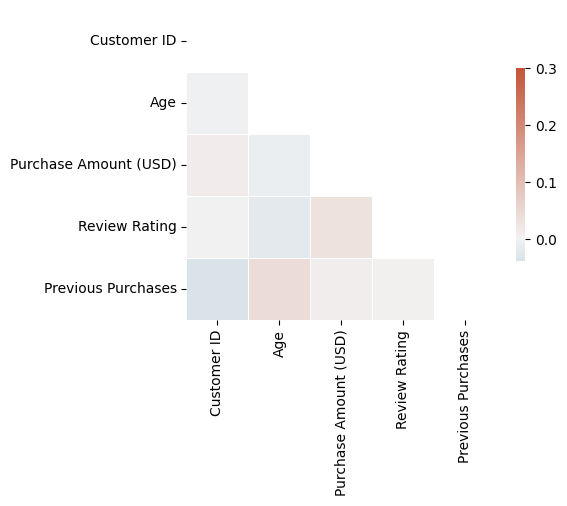

In [23]:
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

- Выше представлена тепловая карта корреляций, которая показывает степень статистической связи между различными переменными датасета: Customer ID, Age, Purchase Amount (USD), Review Rating и Previous Purchases.

- На тепловой карте цвета отражают коэффициенты корреляции между парами переменных. Здесь используется цветовая гамма от светло-серого до темно-красного, где более темные оттенки красного обозначают более сильную положительную корреляцию.

- Большинство ячеек имеют светло-серый цвет, что указывает на слабую или отсутствующую корреляцию.
- Видны 2 ячейки более красного цвета, которые предположительно указывают на наиболее сильные положительные корреляции между переменными в датасете. Это возраст и рейтинг товара и рейтинг и сумма покупки

Также заметили что нет смысла смотреть Customer ID

**Построим матрицу корреляций с переведением переменных Subscription Status, Discount Applied,Promo Code Used и Gender в бинарные переменные**

In [24]:
df['Subscription Status code'] = df['Subscription Status'].apply(lambda x: 1 if x=="Yes" else 0)
df['Discount Applied code'] = df['Discount Applied'].apply(lambda x: 1 if x=="Yes" else 0)
df['Promo Code Used code'] = df['Promo Code Used'].apply(lambda x: 1 if x=="Yes" else 0)
df['Gender code'] = df['Gender'].apply(lambda x: 1 if x=="Male" else 0)
df.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,...,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases,Subscription Status code,Discount Applied code,Promo Code Used code,Gender code
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,...,Express,Yes,Yes,14,Venmo,Fortnightly,1,1,1,1
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,...,Express,Yes,Yes,2,Cash,Fortnightly,1,1,1,1
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,...,Free Shipping,Yes,Yes,23,Credit Card,Weekly,1,1,1,1
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,...,Next Day Air,Yes,Yes,49,PayPal,Weekly,1,1,1,1
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,...,Free Shipping,Yes,Yes,31,PayPal,Annually,1,1,1,1


In [25]:

numeric_coumns = list(df.select_dtypes(include=np.number).columns)
numeric_coumns.remove('Customer ID')

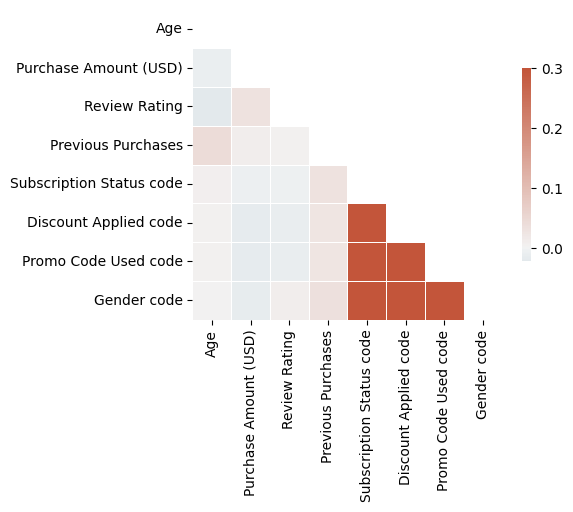

In [26]:
corr = df[numeric_coumns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

**Увидели достаточно странные корреляции между переменными Subscription Status, Discount Applied и Promo Code Used. Посмотрим на них поподробнее**

In [27]:
df['Discount Applied'].value_counts()

No     2223
Yes    1677
Name: Discount Applied, dtype: int64

In [28]:
df['Promo Code Used'].value_counts()

No     2223
Yes    1677
Name: Promo Code Used, dtype: int64

In [29]:
cut_df = df[df['Discount Applied'] == "Yes"]
pd.Series(cut_df['Discount Applied']==cut_df['Promo Code Used'],
          name='check').value_counts()

True    1677
Name: check, dtype: int64

Увидели, что значения Discount Applied и Promo code used полностью совпадают, а поэтому коррелируют. Возможно, в датасет попали данные покупателей, которые при наличии дисконтной карты 100% использовали промокод.

Теперь посмотрим что внутри Subscription Status и Discount Applied

In [30]:
df['Subscription Status code'].value_counts()

0    2847
1    1053
Name: Subscription Status code, dtype: int64

In [31]:
cut_df = df[df['Discount Applied code'] == 1]
pd.Series(cut_df['Discount Applied code']==cut_df['Subscription Status code'],
          name='check').value_counts()

True     1053
False     624
Name: check, dtype: int64

В этом случае получается, что не у всех у кого есть подписка, пользуются дисконтной картой и наоборот, но корреляция все равно имееется

**Теперь посмотрим на распредление покупок по размеру. Заметим, что обувь также обозначается в формате S, M, L, XL**

In [32]:
df['Size'].value_counts()

M     1755
L     1053
S      663
XL     429
Name: Size, dtype: int64

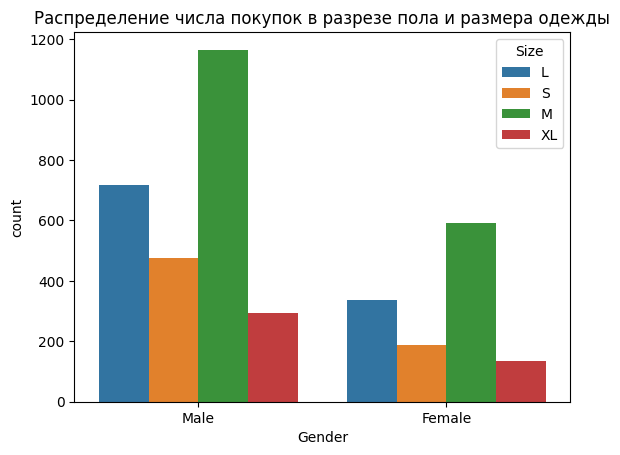

In [33]:
plt.title("Распределение числа покупок в разрезе пола и размера одежды")
sns.countplot(data=df, x='Gender', hue='Size');

На гистограмме изображено распределение числа покупок в разрезе пола и размера одежды. Размеры одежды обозначены цветами: синий для L (Large), оранжевый для S (Small), зеленый для M (Medium) и красный для XL (Extra Large).

Из графика можно сделать следующие выводы:

- Мужчины (Male): Наибольшее количество покупок совершается размера M, за ним следует размер L. Размеры S и XL имеют гораздо меньшее количество покупок среди мужчин.

- Женщины (Female): Для женщин также наибольшее количество покупок приходится на размер M. В отличие от мужчин, у женщин покупок размера L больше, чем размера S, и меньше покупок размера XL.

- Сравнение между полами: У женщин общее количество покупок размера M значительно выше, чем у мужчин, тогда как для размера L ситуация обратная – мужчины совершают больше покупок.

**Тем не менее, вспомним, что кол-во мужчин почти в два раза больше**:

In [34]:
df_male = df[df['Gender'] == 'Male']
df_female = df[df['Gender'] == 'Female']

df_male.shape, df_female.shape

((2652, 22), (1248, 22))

In [35]:
gr_df_male = df_male.groupby('Size')['Customer ID'].count().to_frame().reset_index()
gr_df_male['percent'] = round(gr_df_male['Customer ID']/df_male.shape[0]*100, 2)
gr_df_male

,Size,Customer ID,percent
0,L,716,27.00
1,M,1165,43.93
2,S,476,17.95
3,XL,295,11.12


In [36]:
gr_df_female = df_female.groupby('Size')['Customer ID'].count().to_frame().reset_index()
gr_df_female['percent'] = round(gr_df_female['Customer ID']/df_female.shape[0]*100, 2)
gr_df_female

,Size,Customer ID,percent
0,L,337,27.00
1,M,590,47.28
2,S,187,14.98
3,XL,134,10.74


- Из двух таблиц выше заметим, что в процентах распределение оче6нь похоже, значит кол-во мужчин не сильно влияет на рапределение по размеру


# Матрица корреляций 3.0

In [37]:
# создадим дамми переменные на категорию одежды относительно Accessories
df_category_codes = pd.get_dummies(df['Category'], drop_first=True)
df_category_codes.head()

,Clothing,Footwear,Outerwear
0,1,0,0
1,1,0,0
2,1,0,0
3,0,1,0
4,1,0,0


In [38]:
set(df['Size'])

{'L', 'M', 'S', 'XL'}

In [39]:
def get_size_code(size):
    if size == 'S':
        return 0
    elif size == 'M':
        return 1
    elif size == 'L':
        return 2
    return 3

In [40]:
df['size_code'] = df['Size'].apply(lambda x: get_size_code(x))

In [41]:
df = pd.concat([df, df_category_codes], axis = 1)
df.head(3)

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,...,Payment Method,Frequency of Purchases,Subscription Status code,Discount Applied code,Promo Code Used code,Gender code,size_code,Clothing,Footwear,Outerwear
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,...,Venmo,Fortnightly,1,1,1,1,2,1,0,0
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,...,Cash,Fortnightly,1,1,1,1,2,1,0,0
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,...,Credit Card,Weekly,1,1,1,1,0,1,0,0


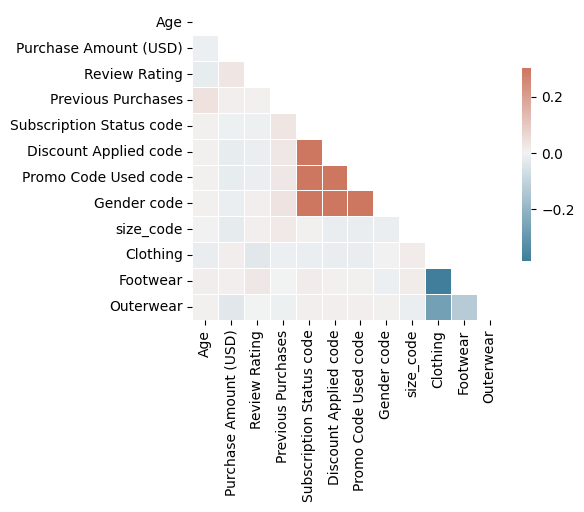

In [42]:
numeric_coumns = list(df.select_dtypes(include=np.number).columns)
numeric_coumns.remove('Customer ID')

corr = df[numeric_coumns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

В финальной матрице мы добавили переменные категории товара, переведя их в дамми переменные. С другими переменными нет сыльно выявленной корреляции. Тем не менее, между собой они достаточно сильно отрицательно коррелируют из-за типа данных.

# Проверка гипотез

## тест Шапиро — Уилка сумма покупки

**Рассмотрим распределение переменной суммы покупки и проверим на нормальность.**

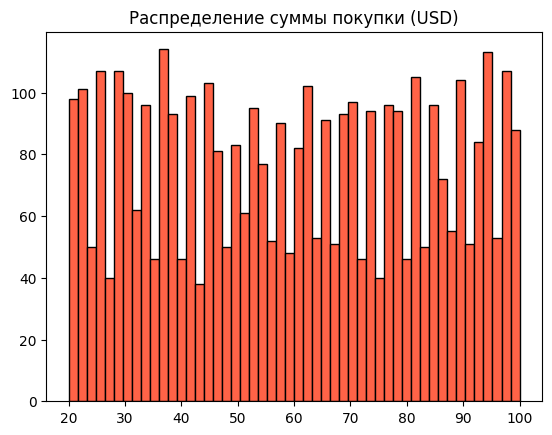

In [43]:
plt.title("Распределение суммы покупки (USD)")
plt.hist(df['Purchase Amount (USD)'],bins = 50, edgecolor = 'black', color = "tomato");

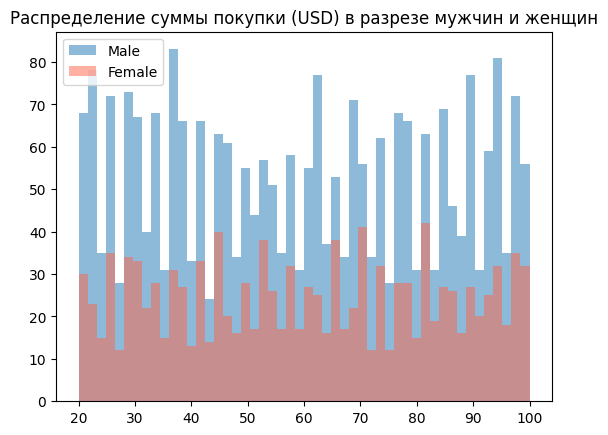

In [51]:
plt.title("Распределение суммы покупки (USD) в разрезе мужчин и женщин")
plt.hist(df_male['Purchase Amount (USD)'], label = 'Male', alpha = 0.5, bins = 50)
plt.hist(df_female['Purchase Amount (USD)'], label = 'Female', alpha = 0.5, color = "tomato", bins = 50)
plt.legend() #выводим легенду
plt.show()

In [56]:
df_female.shape

(1248, 22)

In [44]:
# тест Шапиро — Уилка сумма покупки
stats.shapiro(df['Purchase Amount (USD)'])

ShapiroResult(statistic=0.9502390623092651, pvalue=1.8058719079330814e-34)

Вывод:
- P-значение крайне мало (практически 0), что говорит о том, что у нас есть статистически значимые доказательства того, что данные не следуют нормальному распределению.
- На основе результатов теста Шапиро-Уилка мы можем отклонить гипотезу о нормальности распределения сумм покупок. Таким образом, данные по суммам покупок скорее всего не являются нормально распределенными.

## критерий мана уитни сумма покупки

In [45]:
#критерий мана уитни сумма покупки
stats.mannwhitneyu(df_male['Purchase Amount (USD)'],
                   df_female['Purchase Amount (USD)'])

MannwhitneyuResult(statistic=1625536.5, pvalue=0.3715016876424255)

Интерпретация:
- На основе результатов теста Манна-Уитни нет оснований отклонить нулевую гипотезу о том, что суммы покупок между мужчинами и женщинами статистически не различаются. P-значение 0.3715 слишком высоко, чтобы считать различия статистически значимыми на уровне значимости 0.05.

## тест Шапиро — Уилка рейтинг

**Рассмотрим распределение переменной рейтинга товара проверим на нормальность.**

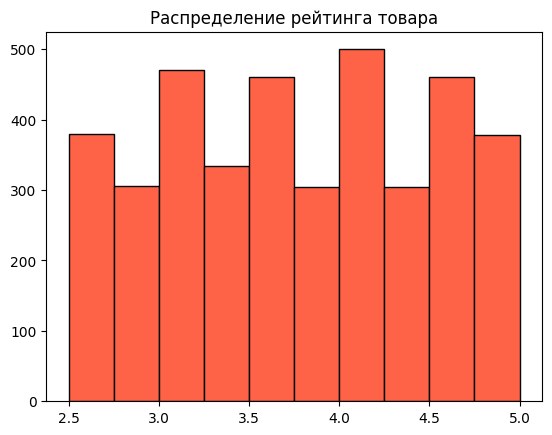

In [63]:
plt.title("Распределение рейтинга товара")
plt.hist(df['Review Rating'],bins = 10, edgecolor = 'black', color = "tomato");

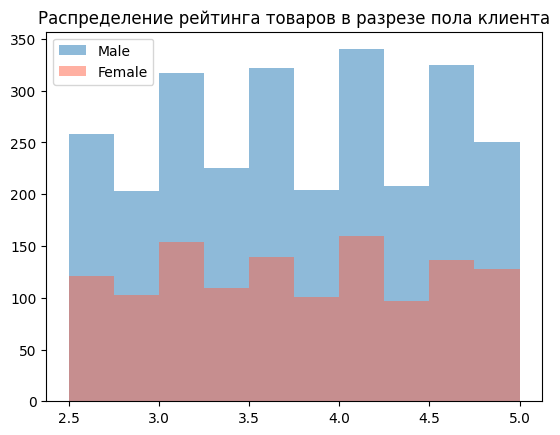

In [64]:
plt.title("Распределение рейтинга товаров в разрезе пола клиента")
plt.hist(df_male['Review Rating'], label = 'Male', alpha = 0.5, bins = 10)
plt.hist(df_female['Review Rating'], label = 'Female', alpha = 0.5, color = "tomato", bins = 10)
plt.legend() #выводим легенду
plt.show()

In [ ]:
# тест Шапиро — Уилка рейтинг товара
stats.shapiro(df['Review Rating'])

ShapiroResult(statistic=0.955574631690979, pvalue=6.472653931291532e-33)

Вывод:
- P-значение крайне мало (практически 0), что говорит о том, что у нас есть статистически значимые доказательства того, что данные не следуют нормальному распределению.
- На основе результатов теста Шапиро-Уилка мы можем отклонить гипотезу о нормальности распределения сумм покупок. Таким образом, данные по суммам покупок скорее всего не являются нормально распределенными.

## критерий мана уитни рейтинг

- теперь посмотрим на распределение рейтинга товаров

In [ ]:
# критерий мана уитни рейтинг товара
stats.mannwhitneyu(df_male['Review Rating'],
                   df_female['Review Rating'])

MannwhitneyuResult(statistic=1671805.5, pvalue=0.60489418014127)

Интерпретация:

- На основе результатов теста Манна-Уитни нет оснований отклонить нулевую гипотезу о том, что рейтинг товаров, покупаемых мужчинами и женщинами статистически не различается. P-значение 0.60489 слишком высоко, чтобы считать различия статистически значимыми на уровне значимости 0.05.

## ЦПТ

**Попробуем привести обе переменные к нормальному значению, используя Центральную предельную теорему**

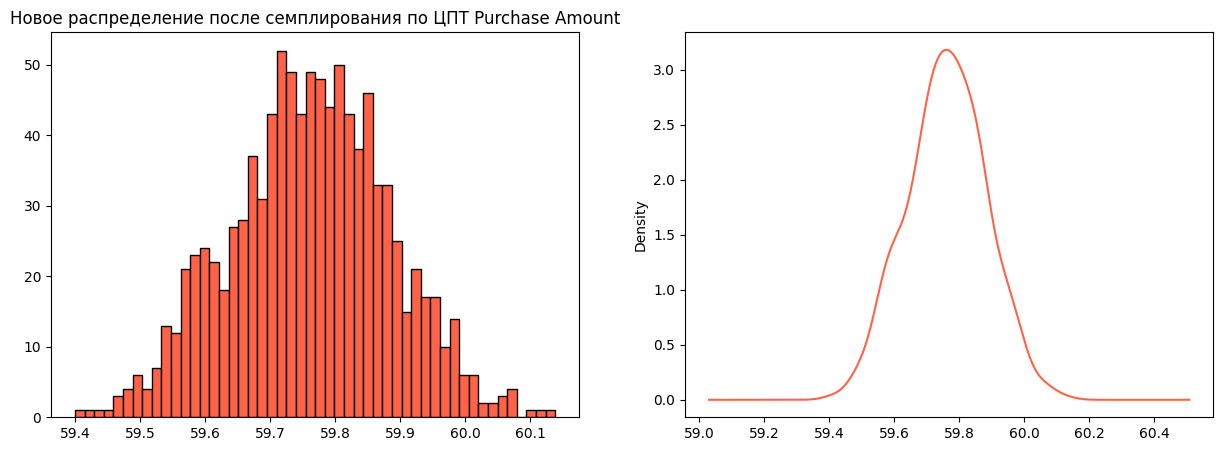

In [ ]:
#ЦЕНТРАЛЬНАЯ ПРЕДЕЛЬНАЯ ТЕОРЕМА ДЛЯ ПРИВЕДЕНИЯ К НОРМАЛЬНОМУ РАСПРЕДЕЛЕНИЮ
res_usd = [] #создаем массив
for i in range(1000):
    res_usd.append(df.sample(frac = 10,replace = True)['Purchase Amount (USD)'].mean())


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Новое распределение после семплирования по ЦПТ Purchase Amount")
plt.hist(res_usd, bins = 50, edgecolor = 'black', color = "tomato")


plt.subplot(1, 2, 2)
pd.Series(res_usd, name='new_purchase_amount').plot(kind = 'density', color = "tomato");

Это уже намного больше внешне похоже на нормальное распределение

In [ ]:
# тест Шапиро — Уилка сумма покупки
stats.shapiro(res_usd)

ShapiroResult(statistic=0.9984134435653687, pvalue=0.49939465522766113)

Вывод:
- P-значение равно 0.49, что гораздо выше общепринятого уровня значимости 0.05. Это означает, что у нас нет статистически значимых доказательств того, что данные не соответствуют нормальному распределению.
- На основе результатов теста Шапиро-Уилка, мы не можем отклонить гипотезу о нормальности распределения сумм покупок. Таким образом, данные по суммам покупок, вероятно, могут быть описаны нормальным распределением.

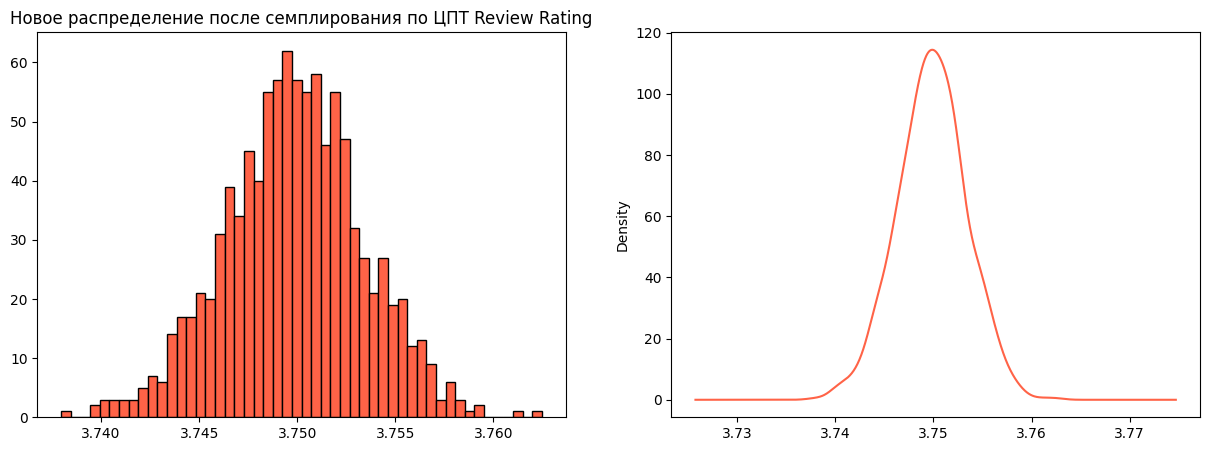

In [ ]:
#ЦЕНТРАЛЬНАЯ ПРЕДЕЛЬНАЯ ТЕОРЕМА ДЛЯ ПРИВЕДЕНИЯ К НОРМАЛЬНОМУ РАСПРЕДЕЛЕНИЮ
res_raitings = [] #создаем массив
#определяем сколько итераций будет проходить
for i in range(1000):
    res_raitings.append(df.sample(frac = 10,replace = True)['Review Rating'].mean())

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Новое распределение после семплирования по ЦПТ Review Rating")
plt.hist(res_raitings, bins = 50, edgecolor = 'black', color = "tomato")

plt.subplot(1, 2, 2)
pd.Series(res_raitings).plot(kind = 'density', color = "tomato");

- внешне стало тоже больше похоже на правду, но не очень. Проерим через тест Шапиро - Уилка

In [ ]:
# тест Шапиро — Уилка рейтинг
stats.shapiro(res_raitings)

ShapiroResult(statistic=0.9989355802536011, pvalue=0.8381488919258118)

Вывод:
- P-значение равно 0.83. Это значение выше традиционного уровня значимости 0.05. Следовательно, у нас нет статистически значимых доказательств против нулевой гипотезы о нормальности распределения данных.
- На основе результатов теста Шапиро-Уилка с p-значением 0.3355 у нас нет достаточных доказательств для отклонения нулевой гипотезы о нормальности распределения данных. Мы не можем утверждать, что данные не являются нормально распределенными на уровне значимости 0.05.

## ttest

**Для примера использования ttest'а посмотрим на средние распределений кол-ва покупок между мужчинами и женщинами**

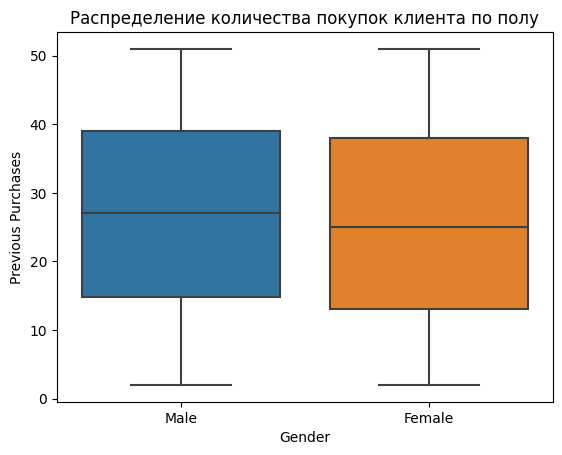

In [73]:
a = df['Previous Purchases']+1

plt.title("Распределение количества покупок клиента по полу")
sns.boxplot(data=df, y=a, x='Gender');

In [74]:
male_purchases_count = df[df['Gender']=='Male']['Previous Purchases']+1
female_purchases_count = df[df['Gender']=='Female']['Previous Purchases']+1

посмотрим на распределение

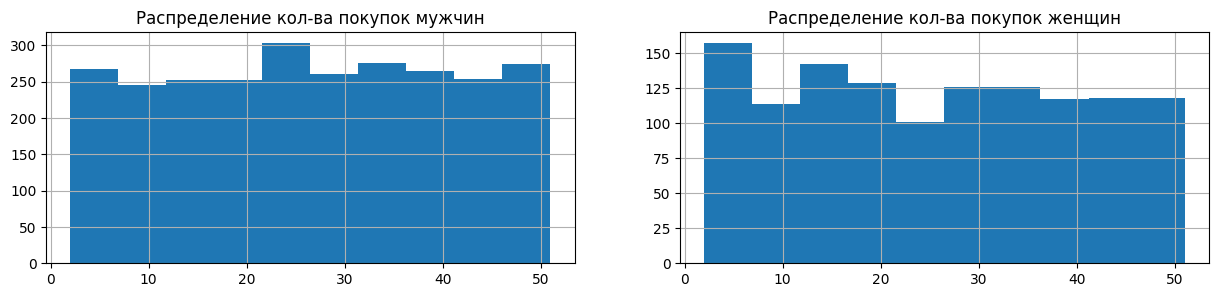

In [75]:
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.title("Распределение кол-ва покупок мужчин")
male_purchases_count.hist()

plt.subplot(1, 2, 2)
plt.title("Распределение кол-ва покупок женщин")
female_purchases_count.hist();

-  приведем к нормальному

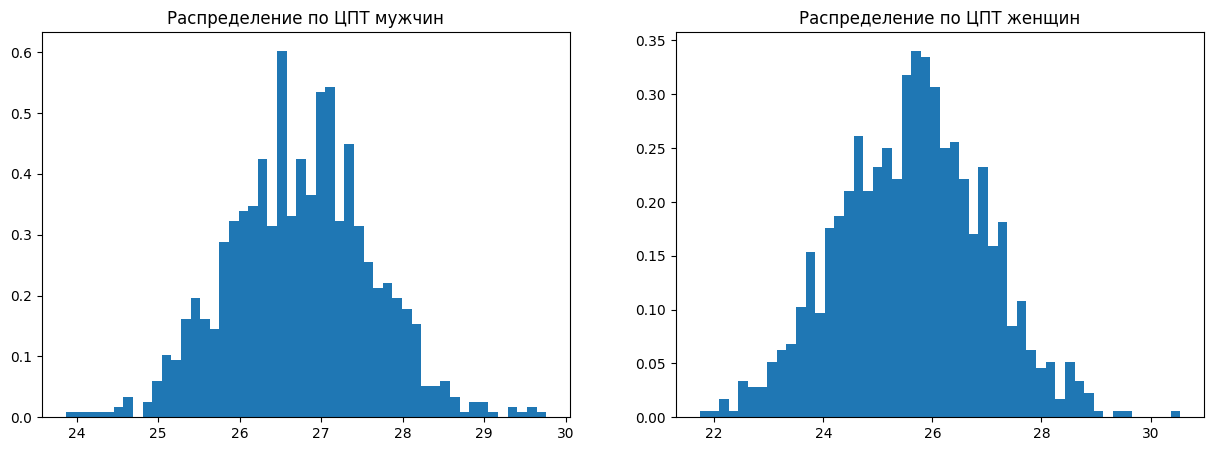

In [76]:
results_m = [] #создаем массив
#определяем сколько итераций будет проходить
for i in range(1000):
    results_m.append(pd.Series(male_purchases_count,
                               name='male_purchases_count').sample(frac = 0.1,
                                                                   replace = True).mean())

results_f = [] #создаем массив
#определяем сколько итераций будет проходить
for i in range(1000):
    results_f.append(pd.Series(female_purchases_count,
                               name='female_purchases_count').sample(frac = 0.1,
                                                                   replace = True).mean())
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Распределение по ЦПТ мужчин")
plt.hist(results_m, density = True, bins = 50)

plt.subplot(1, 2, 2)
plt.title("Распределение по ЦПТ женщин")
plt.hist(results_f, density = True, bins = 50);

In [77]:
print("M =>     ", stats.shapiro(results_m))
print("F =>     ", stats.shapiro(results_f))

M =>      ShapiroResult(statistic=0.9982295036315918, pvalue=0.3923397958278656)
F =>      ShapiroResult(statistic=0.9988354444503784, pvalue=0.7776485085487366)


- pvalue значительно больше 0.05 => H0 не отвергаем - распсределение нормальное

In [78]:
#определяем дисперсии
var_m = male_purchases_count.var()
var_f= female_purchases_count.var()

In [79]:
print(var_m,var_f) #они разные

206.5995283091329 212.55369810622415


In [80]:
#смотрим кол-во наблюдений в выборке
n_f = len(female_purchases_count)
n_m = len(male_purchases_count)


In [81]:
v_m = var_m/n_m
v_f = var_f/n_f
v_m, v_f

(0.07790329121762175, 0.17031546322614113)

In [82]:
#считаем кол-во степеней свободв с поправками уелча
dof_Welch = (v_m + v_f)**2 / (v_m**2/(n_m - 1)+ v_f**2/(n_f -1))
dof_Welch

2411.354837003596

In [83]:
# смотрим критическое значение t-статистики
t_crit = stats.t.ppf(0.95,dof_Welch)
t_crit

1.645485785378765

In [84]:
# проверяем наш критерий
ttest = scipy.stats.ttest_ind(results_f, results_m, equal_var=False)
ttest

TtestResult(statistic=-22.18261731329205, pvalue=3.9454765530556495e-96, df=1726.501636869545)

In [85]:
ttest[0]

-22.18261731329205

In [86]:
def hypothesis_check(t_stat, t_crit):
    if(abs(t_stat) > t_crit):
        print('Отвергаем h0')
    else:
        print('не отвергаем h0')

hypothesis_check(ttest[0], t_crit)

Отвергаем h0


- получилось так, что среднее число покупок мужчин и женщин не равны
- это было не очевидно по графику, поэтому хорошо, что мы проверили


# Линейная регрессия

In [67]:
y = df['Purchase Amount (USD)']
numeric_coumns_x = copy.copy(numeric_coumns)
numeric_coumns_x.remove('Purchase Amount (USD)')
X = df[numeric_coumns_x]

X = sm.add_constant(X, prepend=False)

In [66]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

In [68]:
model = OLS(y, X)
res = model.fit()
print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     Purchase Amount (USD)   R-squared:                       0.003
Model:                               OLS   Adj. R-squared:                  0.001
Method:                    Least Squares   F-statistic:                     1.237
Date:                   Mon, 18 Dec 2023   Prob (F-statistic):              0.262
Time:                           16:01:17   Log-Likelihood:                -17870.
No. Observations:                   3900   AIC:                         3.576e+04
Df Residuals:                       3889   BIC:                         3.583e+04
Df Model:                             10                                         
Covariance Type:               nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

Выше преведены результаты линейной регрессии.
Для решения бизнес-задач, по-хорошему, в наших данных должны пресутсвовать значаения материала изготовления продукта, бренд и т.д. На исследуемых данных она не совсем валидна. Также для проверки качества модели лучше провести тесты на мультиколлинеарность и гетероскедастичность. Тем не менее, так как в нашем случае данные достаточно ограничены, мы этого не делаем

Посмотрим на предворительыне резултаты.

Соответствие модели:

- R-квадрат: 0.003 - Это значение говорит о том, что модель объясняет всего лишь 0.3% изменчивости в 'Сумме покупки (USD)'. Это очень низкое значение, указывающее на слабое соответствие модели.
- Скорректированный R-квадрат: 0.001 - После корректировки на количество предикторов, соответствие остается крайне низким.

Значимость модели:
- F-статистика: 1.237 и Вероятность (F-статистика): 0.262 - Это указывает на то, что модель в целом не является статистически значимой.

Коэффициенты:
- Константа (const): 57.6781 с p-значением близким к нулю указывает на значимое влияние.
- Остальные коэффициенты показывают маленькие и часто не значимые влияния на зависимую переменную. Большинство p-значений выше 0.05, что говорит о их статистической незначимости.

Статистическая значимость предикторов:
- Почти все предикторы имеют высокие p-значения, что говорит о их низкой или отсутствующей статистической значимости в данной модели.

В целом, эта модель показывает очень слабую способность объяснить изменчивость в 'Сумме покупки (USD)'. Низкий R-квадрат, высокие p-значения для большинства предикторов и потенциальные проблемы с мультиколлинеарностью и распределением остатков указывают на то, что модель может быть неадекватной для анализа этих данных.

**Попробуем убрать константу**




In [69]:
y = df['Purchase Amount (USD)']
numeric_coumns_x = copy.copy(numeric_coumns)
numeric_coumns_x.remove('Purchase Amount (USD)')
X = df[numeric_coumns_x]

In [70]:
model = OLS(y, X)
res = model.fit()
print(res.summary())

                                  OLS Regression Results                                  
Dep. Variable:     Purchase Amount (USD)   R-squared (uncentered):                   0.847
Model:                               OLS   Adj. R-squared (uncentered):              0.847
Method:                    Least Squares   F-statistic:                              2161.
Date:                   Mon, 18 Dec 2023   Prob (F-statistic):                        0.00
Time:                           16:01:26   Log-Likelihood:                         -18105.
No. Observations:                   3900   AIC:                                  3.623e+04
Df Residuals:                       3890   BIC:                                  3.629e+04
Df Model:                             10                                                  
Covariance Type:               nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.97

Результаты регрессии выше, построенной методом наименьших квадратов (OLS) предоставляют много ценной информации о связи между различными предикторными переменными и зависимой переменной "Сумма покупки (USD)".

Соответствие модели:
- R-квадрат (несмещенный): 0.847 - Это говорит о том, что около 84,7% изменчивости в "Сумме покупки (USD)" может быть объяснено моделью. Это высокое значение, указывающее на хорошее соответствие.
- Скорректированный R-квадрат (несмещенный): 0.847 - С учетом числа предикторов соответствие остается сильным.

Значимость модели:
- F-статистика: 2161 и Вероятность (F-статистика): 0.00 - Это указывает на общую значимость модели. Очень низкая вероятность здесь (близкая к 0) предполагает, что модель статистически значима.

Коэффициенты:
- Каждая строка в колонке 'coef' представляет эффект каждой предикторной переменной. Положительный коэффициент предполагает прямую связь с суммой покупки, в то время как отрицательный коэффициент предполагает обратную связь.
- Возраст, Рейтинг отзывов, Предыдущие покупки, Код гендера, Код размера, Одежда и Обувь имеют положительные коэффициенты, что означает, что увеличение этих переменных связано с увеличением суммы покупки.
- Код статуса подписки, Код примененной скидки, Код использованного промо-кода и Верхняя одежда показывают либо очень маленькое, либо отрицательное влияние. В частности, 'Код статуса подписки', 'Код примененной скидки' и 'Код использованного промо-кода' имеют коэффициенты, близкие к нулю, и высокие p-значения, что предполагает, что они могут не быть значимыми предикторами в этой модели.

Статистическая значимость предикторов:
- Колонка P>|t| дает p-значение для каждого коэффициента. P-значение меньше 0.05 обычно указывает на статистическую значимость.
- Возраст, Рейтинг отзывов, Предыдущие покупки, Код гендера, Код размера, Одежда и Обувь кажутся статистически значимыми предикторами.
Код статуса подписки, Код примененной скидки, Код использованного промо-кода и Верхняя одежда, похоже, не оказывают значительного влияния на сумму покупки.

In [71]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
numeric_coumns_x = copy.copy(numeric_coumns)
numeric_coumns_x.remove('Purchase Amount (USD)')
X = df[numeric_coumns_x]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

                     feature        VIF
0                        Age   7.652772
1              Review Rating  11.281978
2         Previous Purchases   3.881313
3   Subscription Status code   2.690351
4      Discount Applied code        inf
5       Promo Code Used code        inf
6                Gender code   4.743039
7                  size_code   3.109894
8                   Clothing   2.283856
9                   Footwear   1.456550
10                 Outerwear   1.241362


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Проверим на мультиколлинеарность
VIF измеряет, насколько увеличивается дисперсия коэффициента регрессии переменной из-за наличия линейной зависимости с другими предикторными переменными. Обычно, если VIF больше 5-10, это указывает на проблему мультиколлинеарности.

В вашем результате:

- Переменные как "Review Rating" (VIF = 11.28) и "Age" (VIF = 7.65) имеют высокие VIF значения, что указывает на потенциальную мультиколлинеарность.
- "Discount Applied code" и "Promo Code Used code" имеют VIF равные бесконечности. Это часто происходит, когда переменная полностью или почти полностью коррелирует с другой переменной. Например, если бы каждый раз, когда применялся промокод, применялась скидка, эти две переменные были бы почти идентичны, что приведет к такому высокому VIF.

Для решения проблемы мультиколлинеарности можно исключить одну из коррелирующих переменных, объединить их или использовать методы уменьшения размерности, такие как главные компоненты (PCA).

# Кагортный анализ

In [ ]:
df.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,...,Payment Method,Frequency of Purchases,Subscription Status code,Discount Applied code,Promo Code Used code,Gender code,size_code,Clothing,Footwear,Outerwear
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,...,Venmo,Fortnightly,1,1,1,1,2,1,0,0
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,...,Cash,Fortnightly,1,1,1,1,2,1,0,0
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,...,Credit Card,Weekly,1,1,1,1,0,1,0,0
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,...,PayPal,Weekly,1,1,1,1,1,0,1,0
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,...,PayPal,Annually,1,1,1,1,1,1,0,0


В нашем случае у каждого покупателя совершена 1 покупка

In [ ]:
df['Customer ID'].value_counts()

1       1
2621    1
2593    1
2594    1
2595    1
       ..
1305    1
1306    1
1307    1
1308    1
3900    1
Name: Customer ID, Length: 3900, dtype: int64

Зададим единую дату для всех данных которые у нас есть изначально

In [ ]:
df['date'] = '2023-01-01'
df['date'] = pd.to_datetime(df['date'])

Будем генерировать данные для существующих клиентов (на их часть), но на другие даты

При этом всю другую информацию оставим такой же, ведь наша задача - посчитать ретеншион

In [ ]:
months_list = ['2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01']
subsamplesize_list = [0.55, 0.43, 0.37, 0.32, 0.21]

for m, s in zip(months_list, subsamplesize_list):
    print(m, s)

2023-02-01 0.55
2023-03-01 0.43
2023-04-01 0.37
2023-05-01 0.32
2023-06-01 0.21


In [ ]:
new_df = copy.copy(df)

In [ ]:
def generate_new_data_next_month(month, subsample_size):
    # генерируем новые данные на основе предыдущих
    cur_df = new_df.sample(frac=subsample_size, random_state=42)

    # меняем дату
    cur_df['date'] = cur_df['date'].apply(lambda x: pd.to_datetime(month))

    return cur_df

In [ ]:
# циклом добавляем новые наблюбения в new_df
new_df = copy.copy(df)
for m, s in zip(months_list, subsamplesize_list):
    cur_df = generate_new_data_next_month(m, s)

    new_df = pd.concat([new_df, cur_df])

In [ ]:
new_df['Customer ID'].value_counts()

1685    19
2755    17
863     17
1624    17
1143    17
        ..
2784     1
537      1
532      1
2085     1
2540     1
Name: Customer ID, Length: 3900, dtype: int64

Теперь кажому покупателю соответсвует рандомное кол-во покупок по месяцам

In [ ]:
new_df.columns

Index(['Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category',
       'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season',
       'Review Rating', 'Subscription Status', 'Shipping Type',
       'Discount Applied', 'Promo Code Used', 'Previous Purchases',
       'Payment Method', 'Frequency of Purchases', 'Subscription Status code',
       'Discount Applied code', 'Promo Code Used code', 'Gender code',
       'size_code', 'Clothing', 'Footwear', 'Outerwear', 'date'],
      dtype='object')

In [ ]:
new_df['CohortDate'] = new_df.groupby('Customer ID')['date'].transform('min')

In [ ]:
new_df['InvoiceYear'] = new_df['date'].dt.year
new_df['InvoiceMonth'] = new_df['date'].dt.month

In [ ]:
new_df['CohortYear'] = new_df['CohortDate'].dt.year
new_df['CohortMonth'] = new_df['CohortDate'].dt.month

In [ ]:
new_df

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,...,size_code,Clothing,Footwear,Outerwear,date,CohortDate,InvoiceYear,InvoiceMonth,CohortYear,CohortMonth
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,...,2,1,0,0,2023-01-01,2023-01-01,2023,1,2023,1
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,...,2,1,0,0,2023-01-01,2023-01-01,2023,1,2023,1
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,...,0,1,0,0,2023-01-01,2023-01-01,2023,1,2023,1
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,...,1,0,1,0,2023-01-01,2023-01-01,2023,1,2023,1
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,...,1,1,0,0,2023-01-01,2023-01-01,2023,1,2023,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347,1348,44,Male,Sweater,Clothing,95,Vermont,M,Cyan,Summer,...,1,1,0,0,2023-06-01,2023-01-01,2023,6,2023,1
1672,1673,18,Male,Boots,Footwear,73,South Carolina,L,Gold,Fall,...,2,0,1,0,2023-06-01,2023-01-01,2023,6,2023,1
316,317,36,Male,Handbag,Accessories,22,California,M,Charcoal,Fall,...,1,0,0,0,2023-06-01,2023-01-01,2023,6,2023,1
2582,2583,19,Male,Dress,Clothing,98,South Dakota,S,Indigo,Fall,...,0,1,0,0,2023-06-01,2023-01-01,2023,6,2023,1


In [ ]:
new_df['YearDif'] = new_df.InvoiceYear-new_df.CohortYear
new_df['MonthDif'] = new_df.InvoiceMonth-new_df.CohortMonth

In [ ]:
new_df.YearDif.value_counts()

0    18914
Name: YearDif, dtype: int64

В искуственно сгенерированных данных только 1 год (2023), поэтому 0

In [ ]:
new_df.MonthDif.value_counts()

0    3900
4    3789
5    3283
3    3198
2    2599
1    2145
Name: MonthDif, dtype: int64

Разница в месяцах между последним и первым месяцем покупок представлена выше

In [ ]:
new_df['CohortIndex'] = new_df.YearDif *12 + new_df.MonthDif +1

In [ ]:
new_df['CohortIndex'].value_counts()

1    3900
5    3789
6    3283
4    3198
3    2599
2    2145
Name: CohortIndex, dtype: int64

In [ ]:
cohort_data = new_df.groupby(['CohortDate', 'CohortIndex'])['Customer ID'].apply(pd.Series.nunique).reset_index()
cohort_data

,CohortDate,CohortIndex,Customer ID
0,2023-01-01,1,3900
1,2023-01-01,2,2145
2,2023-01-01,3,2100
3,2023-01-01,4,2128
4,2023-01-01,5,2281
5,2023-01-01,6,1958


In [ ]:
cohort_table = cohort_data.pivot(index = 'CohortDate',\
                                 columns = 'CohortIndex',\
                                values = 'Customer ID')

cohort_table

CohortIndex,1,2,3,4,5,6
CohortDate,,,,,,
2023-01-01,3900,2145,2100,2128,2281,1958


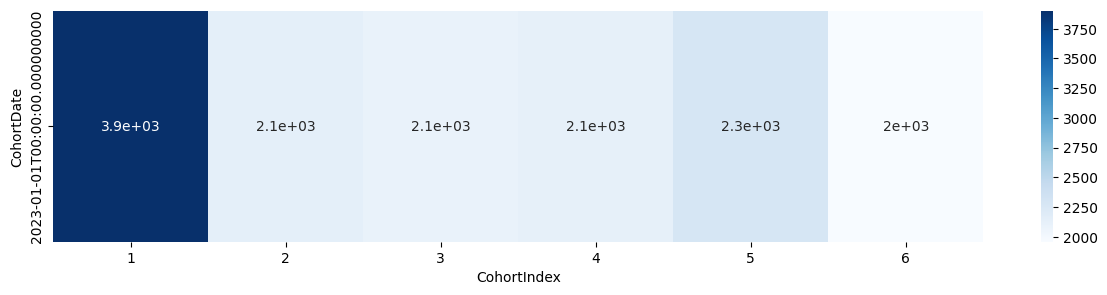

In [ ]:
plt.figure(figsize = (15,3))
sns.heatmap(cohort_table, annot = True, cmap = 'Blues');

На тепловой карте выше видно, что самое большое кол-во покупателей сделали покупку в первый месяц и был небольшой подьем в 5й месяц. учитывая, что данные сгенерированны искуственно и рандомно эти показатели могут изименится. Тем не менее, если бы они были настоящими мы бы обратили более пристальное внимание на падения и подьемы

In [ ]:
#retention rate
#опроеделим размер когорты
cohort_size = cohort_table.iloc[:, 0]
cohort_size

CohortDate
2023-01-01    3900
Name: 1, dtype: int64

In [ ]:
retention = cohort_table.divide(cohort_size, axis = 0)
retention

CohortIndex,1,2,3,4,5,6
CohortDate,,,,,,
2023-01-01,1.0,0.55,0.538462,0.545641,0.584872,0.502051


Привели подобную таблицу как выше, но уже в процентном виде

# Вывод

- Большинство анализов плохо работают на выбранных данных из-за их ограниченности. Компании стоит расширить датасет для более целостного анализа
- Исходя из проверки гипотез, можно сделать вывод что рейтинг товара и его цена не зависит от типа товара (мужской или женский) *беря за гипотезу что мужчины покупают товары для мужчин, а женщины для женщин
- Отсутствуют сильные корреляции между нашими показателями
- Портрет наиболее часто встречающегося потребителя: размер M, нет подписки, не использует скидки и промокоды. Исходя из предоставленных данных, клиентов - мужчин больше и они чаще совершают покупки (ttest). Наиболее частые категории товаров это одежда и аксессуары. Живут в разных штатах США с разными погодными условиями, а также достаточно редко совершают покупки.